# Lab 4: Comparison of Binary Classifiers

All columns in this dataset are numerical.

The `type` column is the *dependent variable* or *target* for classification, while all other columns are the *predictors*. We will use the common convention to refer to the predictors as **X** and to the target as **y**.  

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

# Task 1

In [62]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA

In [63]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [64]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

Check for missing values and outliers.

In [65]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We will do this in three slices.

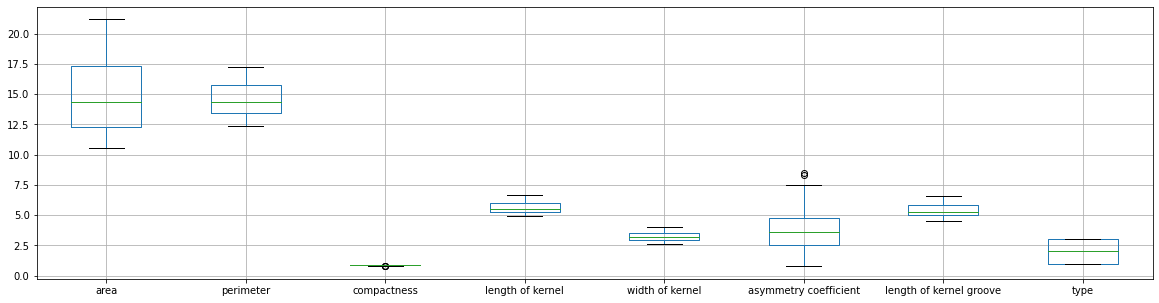

In [66]:
df.loc[:,'area':'type'].boxplot(figsize=(20,5))
plt.show()

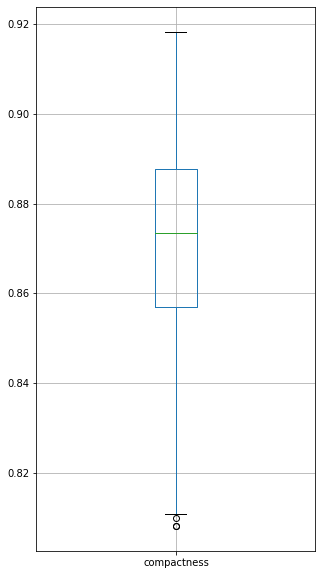

In [67]:
df.boxplot(column='compactness', figsize=(5,10))
plt.show()

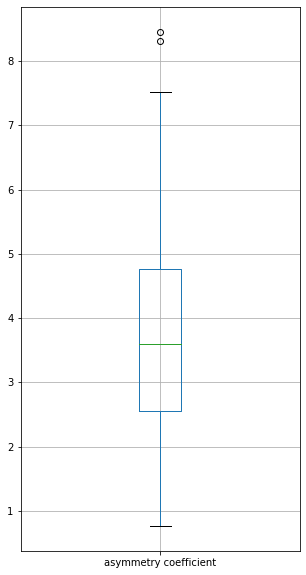

In [68]:
df.boxplot(column='asymmetry coefficient', figsize=(5,10))
plt.show()

'asymmetry coefficient' and 'compactness' appear to have prominent outliers. We will apply log transformation followed by `RobustScaler` to 'asymmetry coefficient' and 'compactness'. To all other predictor columns we will apply `StandardScaler`.  

## Data Preparation

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the two columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [69]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient', 'compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [70]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [71]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [72]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Before we split the data we need to convert the 'type' coloun from categorical {1, 2 ,3} to binary {0, 1}. I do this by mapping 1 to 0, and mapping 2 and 3 to 1.

In [73]:
scale_mapper = {
    1: 0,
    2: 1,
    3: 1
}

df['type'] = df['type'].replace(scale_mapper)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [74]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

# Task 2
## Grid Search for Best Parameters of Classifiers

### SVM

In [75]:
#Check for all available paramerters
svm.SVC(probability=True).get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

From the list above we can select which parameters we wish to change

In [76]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100, 1000],  
    'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'svm__kernel': ['rbf', 'linear', 'poly']
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.970:
Best parameters:  {'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


### Random Forest

In [77]:
#Check for all available paramerters
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

From the list above we can select which parameters we wish to change

In [78]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [1, 5, 10, 20, 30],
    'rf__max_depth': [2, 4, 6, 8, 10],
    'rf__max_samples': [5, 10, 20]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.923:
Best parameters:  {'rf__max_depth': 10, 'rf__max_samples': 20, 'rf__n_estimators': 20}
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


## Compare Classifiers on Test Set

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same tor (type one rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced tor values between 0 and 1.

#### Note: ttr (type two/three rate)

In [79]:
mean_tor = np.linspace(start=0, stop=1, num=100)

In [80]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _tor, _ttr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_tor
    _ttr_transformed = np.array([interp(mean_tor, _tor, _ttr)])
    
    # compute the area under the curve
    _auc = auc(_tor, _ttr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _ttr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [81]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_ttr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_ttr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

<ipython-input-80-604fb1b2da09>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _ttr_transformed = np.array([interp(mean_tor, _tor, _ttr)])
<ipython-input-80-604fb1b2da09>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _ttr_transformed = np.array([interp(mean_tor, _tor, _ttr)])


We will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

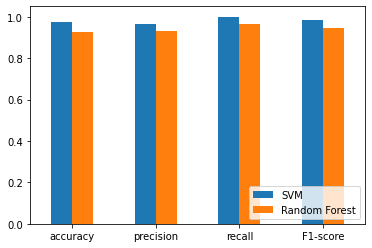

In [82]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both classifiers perform well with SVM being slightly better. Most important, both have high recall for class 1, which is what we were looking for. We can pick SVM to train a final model on the whole dataset. These results will vary slightly when you run this notebook again. Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.

We can also examine the ROC curves of the two classifiers for class 1.

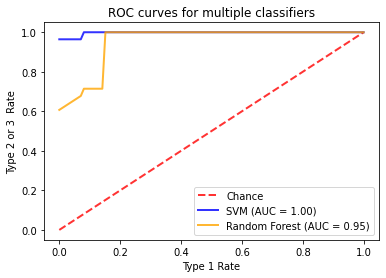

In [83]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_tor, SVM_ttr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_tor, RF_ttr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('Type 1 Rate')
plt.ylabel('Type 2 or 3  Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed line). 

## Train a Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [84]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [85]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Task 3
## kNN - k Nearest Neighbour

In [86]:
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [87]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'knn__n_neighbors': [5, 10, 15, 25], 
    'knn__weights': ['uniform', 'distance']
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
kNN_best_params = search.best_params_
kNN_best_model = search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [88]:
kNN_accuracy, kNN_precision, kNN_recall, kNN_f1_score, kNN_ttr, kNN_auc = evaluate_model(X_test, y_test, kNN_best_model)

<ipython-input-80-604fb1b2da09>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _ttr_transformed = np.array([interp(mean_tor, _tor, _ttr)])


## Compare kNN to SVM and Random Forest

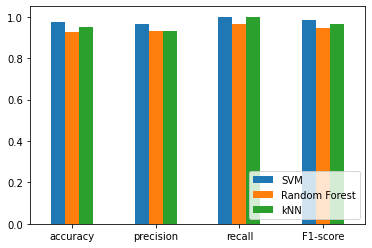

In [89]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
kNN_metrics = np.array([kNN_accuracy, kNN_precision, kNN_recall, kNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, "kNN" : kNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

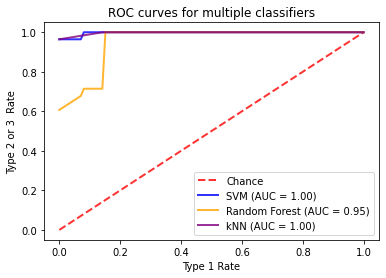

In [90]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_tor, SVM_ttr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_tor, RF_ttr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_tor, kNN_ttr[0,:], lw=2, color='purple', label='kNN (AUC = %0.2f)' % (kNN_auc), alpha=0.8)
plt.xlabel('Type 1 Rate')
plt.ylabel('Type 2 or 3  Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

From the graphs above we can see that [kNN] is not as effective as [SVM] or Random forest. A different method will need to be attempted

## MLP Classifier

In [91]:
from sklearn.neural_network import MLPClassifier
MLPClassifier().get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [92]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('MLP', MLPClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'MLP__alpha': [1.0, 0.1, 0.01, 0.001, 0.0001],
    'MLP__max_iter': [10 ,20 ,50, 100]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

aximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sk

In [93]:
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_ttr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

<ipython-input-80-604fb1b2da09>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _ttr_transformed = np.array([interp(mean_tor, _tor, _ttr)])


## Compare MLP Classifier to SVM, Random Forest and kNN

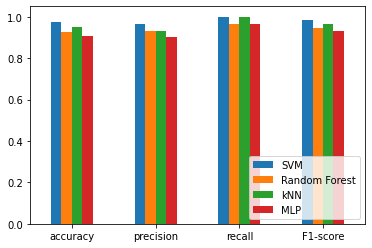

In [94]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
kNN_metrics = np.array([kNN_accuracy, kNN_precision, kNN_recall, kNN_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, "kNN" : kNN_metrics, 'MLP' : MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

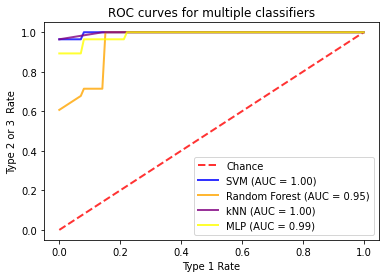

In [95]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_tor, SVM_ttr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_tor, RF_ttr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_tor, kNN_ttr[0,:], lw=2, color='purple', label='kNN (AUC = %0.2f)' % (kNN_auc), alpha=0.8)
plt.plot(mean_tor, MLP_ttr[0,:], lw=2, color='yellow', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('Type 1 Rate')
plt.ylabel('Type 2 or 3  Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

After running this mutiple times the best option appears to be [SVC] but this is interchangeable with [MLC] depending on the run